In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import display, Math

data = pd.DataFrame({'h':           [60.05, 60.4, 60.4, 60.4, 50.4], # in mm
                     'ID':          [9.5, 7.5, 7.75, 7.25, 16], 
                     'OD':          [14.75, 12.0, 12.0, 12.0, 21.5],
                     'thickness':   [np.mean([1.5, 1.5, 2.0]),
                                     np.mean([1.1, 1.5, 1.1, 1.9]),
                                     np.mean([1.5, 2.1]),
                                     np.mean([1.9, 2.0]),
                                     np.mean([2.1, 2.1, 2.5])]
                     })

for key, val in data.items():
    data[key] = val / 10
print(data)

       h     ID     OD  thickness
0  6.005  0.950  1.475   0.166667
1  6.040  0.750  1.200   0.140000
2  6.040  0.775  1.200   0.180000
3  6.040  0.725  1.200   0.195000
4  5.040  1.600  2.150   0.223333


In [43]:
epsilon = data['ID'] / data['OD']
thickness = data['OD'] - data['ID']

In [44]:
def od(h, m, b):
    return 2 * (m * h + b)

popt, pcov = curve_fit(od, data['h'], data['OD'])

In [45]:
md_math = f"$OD = {popt[0]}h + {popt[1]}$"
display(Math(md_math))

<IPython.core.display.Math object>

In [46]:
# Distance from stage to crossing pt at OD = 0
OD = 0
h_0 = ((OD + 2.5 / 10) - popt[1]) / popt[0]

# Distance from stage to objective at OD = -2.5
OD = -2.5 / 10
h_obj = ((OD + 2.5 / 10) - popt[1]) / popt[0]

# This will assume the obj is filled. To fix this, we can measure the height to the objective and remove the -2.5 mm assumption
WD = h_obj - h_0
print(h_obj, WD)

# Alternatively, we can assume the manufacturer WD of 2mm and solve
WD = 2 / 10
h_obj = h_0 + 2 / 10
print(h_obj, WD)

# Because of the disparity, we will use the one with 2mm WD and calculate diameters from there.
OD = od(h_obj, *popt)
print(f'{np.abs(OD)} will be the starting outer diameter of simulations')

print(f'{np.arctan(-OD / (h_obj-h_0))} will be the angle of simulations')

7.44363114247511 0.5573118140052289
7.086319328469881 0.2
0.3205672345588173 will be the starting outer diameter of simulations
-1.012992674814683 will be the angle of simulations


In [47]:
# ID will assume the same slope, but find a new y intercept in order to determine the acceptance diameter 
def id(h, b):
    return 2 * (popt[0] * h + b)

popt2, pcov = curve_fit(id, data['h'], data['ID'])

In [48]:
from IPython.display import display, Math
md_math = f"$ID = {popt[0]}h + {popt2[0]}$"
display(Math(md_math))

<IPython.core.display.Math object>

In [49]:
ID = id(h_obj, *popt2)
print(f'{np.abs(ID)} will be the starting inner diameter of simulations')

0.16443276544118213 will be the starting inner diameter of simulations


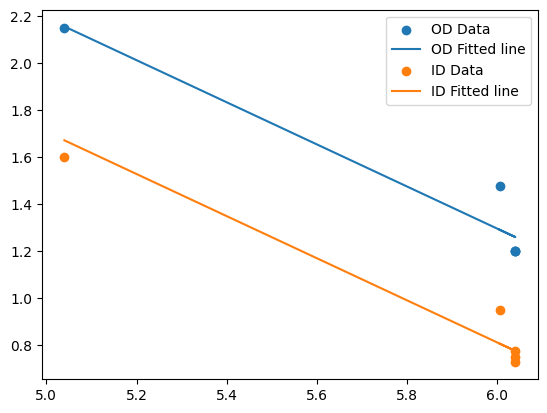

In [50]:
plt.figure()
ax = plt.axes()
ax.scatter(data['h'], data['OD'], label='OD Data')
ax.plot(data['h'], od(data['h'], *popt), label='OD Fitted line')
ax.scatter(data['h'], data['ID'], label='ID Data')
ax.plot(data['h'], id(data['h'], *popt2), label='ID Fitted line')
ax.legend()
plt.show()

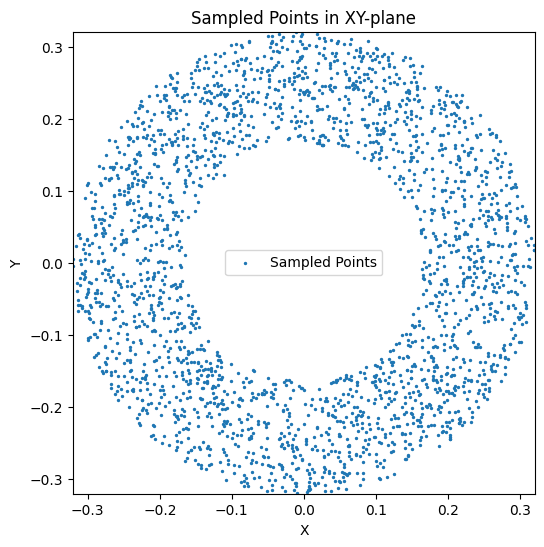

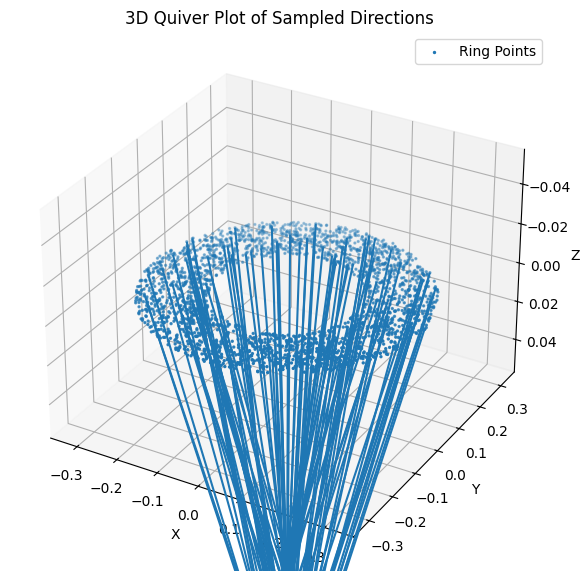

In [51]:
r_min, r_max = ID, OD
angle_min = np.arctan(-2.5 / 2)
angle_max = angle_min
def sampler():
    # Sample angle and radius for starting location
    phi = np.random.uniform(0, 2 * np.pi)
    r =np.sqrt(np.random.uniform(r_min ** 2, r_max ** 2))

    # Create ring
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    location = (x, y, 0)

    # Sample injection angles directional cosines
    theta = np.random.uniform(angle_min, angle_max)

    # Compute directional cosines
    mu_x = np.sin(theta) * np.cos(phi)
    mu_y = np.sin(theta) * np.sin(phi)
    mu_z = np.cos(theta)
    directional_cosines = (mu_x, mu_y, mu_z)
    
    return location, directional_cosines 

# Generate samples
n_samples = 2500
locations = []
directions = []

for _ in range(n_samples):
    loc, dir_cos = sampler()
    locations.append(loc)
    directions.append(dir_cos)

locations = np.array(locations)
directions = np.array(directions)

# Plot ring (XY-plane)
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(locations[:,0], locations[:,1], s=2, label="Sampled Points")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Sampled Points in XY-plane")
ax.set_xlim(-r_max, r_max)
ax.set_ylim(-r_max, r_max)
ax.set_aspect('equal')
ax.legend()
plt.show()

# 3D Quiver plot (direction vectors)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

# Plot points
ax.scatter(locations[:,0], locations[:,1], locations[:,2], s=2, label='Ring Points')

# Plot direction vectors
scale = 0.5  # Adjust arrow length for visibility
for i in range(0, n_samples, 25):  # Reduce number of arrows plotted for clarity
    ax.quiver(locations[i,0], locations[i,1], locations[i,2], 
              directions[i,0], directions[i,1], directions[i,2], 
              length=scale, normalize=True)
ax.invert_zaxis()
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D Quiver Plot of Sampled Directions")
ax.legend()
plt.show()